<a href="https://colab.research.google.com/github/dviva1972/denvlaiva/blob/master/DLL_hw_9_99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DLL

## Домашняя работа 9 | Computer Vision - 1  | SSD

## Иванов Денис

#### Решить задачу детекции на основе SSD для датасета 
https://github.com/Shenggan/BCCD_Dataset


In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 933 kB/s 


In [2]:
import numpy as np 
import pandas as pd
import torch
from torchvision import models
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchvision

from d2l import torch as d2l

from PIL import Image, ImageDraw
import os
import sys
from google.colab import drive 
import json
import re
import random
from math import sqrt
%matplotlib inline

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = '/content/drive/My Drive/DLL/BCCD_Dataset-master/BCCD/'

### Базовое представление о типичном изображении датасета


Тип кровяных телец WBC


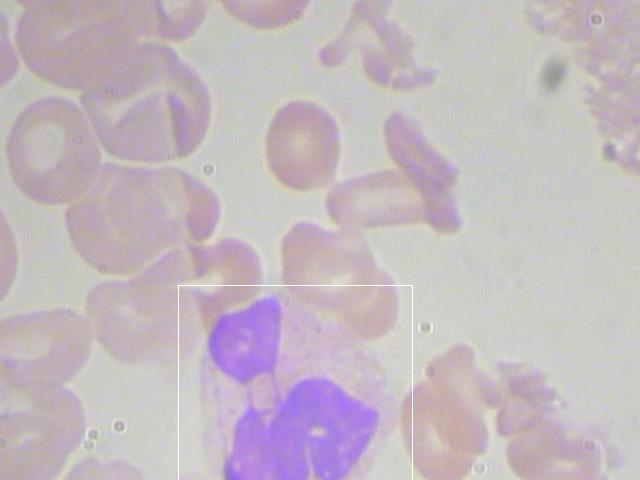

In [5]:
with open(PATH+'Annotations/BloodImage_00350.xml') as f:  
    reader = f.read()

img = Image.open(PATH+'JPEGImages/BloodImage_00350.jpg') 

xmin = int(re.findall('(?<=<xmin>)[0-9]+?(?=</xmin>)', reader)[-1])
xmax = int(re.findall('(?<=<xmax>)[0-9]+?(?=</xmax>)', reader)[-1])
ymin = int(re.findall('(?<=<ymin>)[0-9]+?(?=</ymin>)', reader)[-1])
ymax = int(re.findall('(?<=<ymax>)[0-9]+?(?=</ymax>)', reader)[-1])

b_type = re.findall('(?<=<name>)[A-Za-z]{3,10}?(?=</name>)', reader)[-1]

origin_img = img.copy()

draw             = ImageDraw.Draw(origin_img)
draw.rectangle(xy=[(xmin,ymin), (xmax,ymax)])

print('Тип кровяных телец', b_type)
origin_img

In [6]:
all_img_folder        = os.listdir(PATH+'JPEGImages')
all_annotation_folder = os.listdir(PATH+'Annotations')

all_img_name          = []
img_folder_path       = PATH+'JPEGImages'
all_img_name         += list(map(lambda x: '/'+ x, os.listdir(img_folder_path)))
all_img_name          = sorted(all_img_name)

all_annotation_name   = []
annotation_folder_path= PATH+'Annotations'
all_annotation_name  += list(map(lambda x: '/'+ x, os.listdir(annotation_folder_path)))
all_annotation_name   = sorted(all_annotation_name)

print(len(all_img_name), all_img_name[0])
print(len(all_annotation_name), all_annotation_name[0])

364 /BloodImage_00000.jpg
364 /BloodImage_00000.xml


### Сбор и предварительный анализ данных для датасета

Читка аннотаций

In [7]:
df_annot = pd.DataFrame(columns = ['image_num', 'fich_type', 
                                   'X_min', 'y_max', 'X_max', 'y_min',
                                   'img_width', 'img_height'])

for i in all_annotation_name:
    with open(annotation_folder_path + i) as f:  
        reader = f.read()
        b_type = re.findall('(?<=<name>)[A-Za-z]{3,10}?(?=</name>)', reader)
        
        iwid = re.findall('(?<=<width>)[0-9]+?(?=</width>)', reader)[0]
        ihgh = re.findall('(?<=<height>)[0-9]+?(?=</height>)', reader)[0]

        xmin = re.findall('(?<=<xmin>)[0-9]+?(?=</xmin>)', reader)
        ymax = re.findall('(?<=<ymax>)[0-9]+?(?=</ymax>)', reader)
        xmax = re.findall('(?<=<xmax>)[0-9]+?(?=</xmax>)', reader)
        ymin = re.findall('(?<=<ymin>)[0-9]+?(?=</ymin>)', reader)
        

        code = ''.join(re.findall('(?<=/BloodImage_)[0-9]{5}?(?=.xml)', i))

        for j in range(len(xmin)):
            string = [code , b_type[j], 
                      xmin[j],  ymax[j], xmax[j], ymin[j], 
                      iwid, ihgh]
            df_annot.loc[len(df_annot)] = string
df_annot.tail()

,image_num,fich_type,X_min,y_max,X_max,y_min,img_width,img_height
4883,00410,Platelets,239,321,291,275,640,480
4884,00410,Platelets,121,320,189,260,640,480
4885,00410,Platelets,57,167,104,119,640,480
4886,00410,Platelets,1,327,29,286,640,480
4887,00410,WBC,367,394,611,166,640,480


In [8]:
# Классификация видов объектов / кровяных телец

d = {'RBC': 0, 'WBC': 1, 'Platelets': 2}

df_annot['fich_code'] = [d[i] for i in df_annot['fich_type']]
df_annot['fich_code'].value_counts()

0    4155
1     372
2     361
Name: fich_code, dtype: int64

In [10]:
# формирование картинок к обучению 
df_annot['board_noise'] = [random.randint(0, 10) for i in range(len(df_annot))]

In [11]:
df_annot.iloc[:,2:] = df_annot.iloc[:,2:].astype(float)
df_annot.head(1)

,image_num,fich_type,X_min,y_max,X_max,y_min,img_width,img_height,fich_code,board_noise
0,00000,WBC,260.0,376.0,491.0,177.0,640.0,480.0,1.0,8.0


In [12]:
df_annot['X_cut_vnesh_min'] = [max(df_annot.iloc[i,2]- df_annot.iloc[i,9],0) 
                                                for i in range(len(df_annot))]
df_annot['y_cut_vnesh_max'] = [min(df_annot.iloc[i,3]+ df_annot.iloc[i,9], df_annot.iloc[i,7]) 
                                                for i in range(len(df_annot))]
df_annot['X_cut_vnesh_max'] = [min(df_annot.iloc[i,4]+ df_annot.iloc[i,9], df_annot.iloc[i,6]) 
                                                for i in range(len(df_annot))]
df_annot['y_cut_vnesh_min'] = [max(df_annot.iloc[i,5]- df_annot.iloc[i,9], 0) 
                                                for i in range(len(df_annot))]
df_annot.head(3)

,image_num,fich_type,X_min,y_max,X_max,y_min,img_width,img_height,fich_code,board_noise,X_cut_vnesh_min,y_cut_vnesh_max,X_cut_vnesh_max,y_cut_vnesh_min
0,00000,WBC,260.0,376.0,491.0,177.0,640.0,480.0,1.0,8.0,252.0,384.0,499.0,169.0
1,00000,RBC,78.0,435.0,184.0,336.0,640.0,480.0,0.0,3.0,75.0,438.0,187.0,333.0
2,00000,RBC,63.0,336.0,169.0,237.0,640.0,480.0,0.0,1.0,62.0,337.0,170.0,236.0


In [13]:
df_annot = df_annot[df_annot.index <4600]  #  остальное для тестирования модели

Читка картинок и аннотаций

In [14]:
all_img_num = df_annot.image_num.unique().tolist()
len(all_img_num)

346

In [15]:
img_tens_list =[]
tsfm=transforms.Compose([transforms.Resize([256, 256]), 
                         transforms.ToTensor()])

for i in range(len(all_img_num)):
    df_temp = df_annot[df_annot.image_num == all_img_num[i]]
    with Image.open(img_folder_path + '/BloodImage_'+ all_img_num[i]+'.jpg').convert("RGB") as img: 

        for j in range(len(df_temp)):
            string = df_temp.iloc[j,:]
            img_crop = img.crop((string[10], string[13],
                                 string[12], string[11]))
            img_crop = tsfm(img_crop)  
            
            img_tens_list.append(img_crop)

len(img_tens_list), img_tens_list[0].shape

(4600, torch.Size([3, 256, 256]))

Картинка к обучению

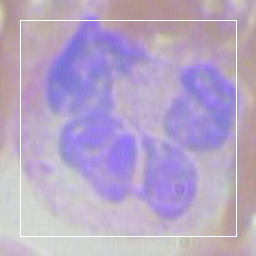

In [16]:
origin_img = transforms.ToPILImage()(img_tens_list[0])
draw       = ImageDraw.Draw(origin_img)
draw.rectangle(xy=[(20,20), (236,236)])

origin_img

In [17]:
np_annot_target = np.zeros((len(df_annot),1,5))
Li = []

for i in df_annot.index:

        string = df_annot.iloc[i,:]        
        np_annot_target[i] = [[string[8],  20, 20, 236, 236]] 
                       

np_annot_target.shape

(4600, 1, 5)

###  DataLoader

In [18]:
class B_Dataset(torch.utils.data.Dataset):
    def __init__(self, is_train = True):
        self.features, self.labels = img_tens_list, torch.FloatTensor(np_annot_target)
        print('read ' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx]) ###

    def __len__(self):
        return len(self.features)

In [19]:
def load_data(batch_size):
    train_iter = torch.utils.data.DataLoader(B_Dataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(B_Dataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

### Базовые компоненты модели

In [20]:
# Class Prediction Layer         класс

def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

In [21]:
# Bounding Box Prediction Layer | Ограничивающая рамка

def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, 
                     kernel_size=3, padding=1)

In [22]:
# Concatenating Predictions 

def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [24]:
# Блок понижающей дискретизации

def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [25]:
# Base Network Block

def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
                   
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)

def forward(x, block):
    return block(x)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 64, 32, 32])

### Сборка модели

In [26]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128) #
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [27]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [28]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],[0.88, 0.961]]
ratios= [[1, 3, 5]] * 5 # [1, 2, 0.5]
num_anchors = len(sizes[0]) + len(ratios[0]) - 1
num_anchors

4

In [29]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128] # [32, 64, 64, 64, 64]#
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(
                self, f'cls_{i}',
                cls_predictor(idx_to_in_channels[i], num_anchors,
                              num_classes))
            setattr(self, f'bbox_{i}',
                    bbox_predictor(idx_to_in_channels[i], num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1,
                                      self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [30]:
net = TinySSD(num_classes=3)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 4])
output bbox preds: torch.Size([32, 21776])


### Training

#### Reading the Dataset and Initializing the Model

In [31]:
batch_size = 64
train_iter, _ = load_data(batch_size)

read 4600 training examples
read 4600 validation examples


In [32]:
device, net = d2l.try_gpu(), TinySSD(num_classes=3)
trainer = torch.optim.SGD(net.parameters(), lr=0.5, weight_decay=5e-4)

#### Defining Loss and Evaluation Functions

In [33]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [34]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float(
        (cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

#### Training the Model

class err 5.03e-05, bbox mae 4.17e-03
12621.2 examples/sec on cuda:0


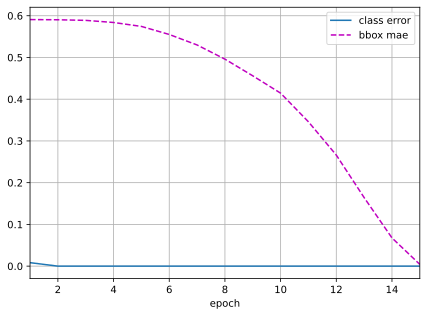

In [35]:
num_epochs, timer = 15, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'],
                        figsize=(7, 5))
net = net.to(device)

for epoch in range(num_epochs):
    # Sum of training accuracy,     of examples in sum of training accuracy,
    # Sum of absolute error,        of examples in sum of absolute error 
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)

        # Generate multiscale anchor boxes and predict their classes and offsets      
        anchors, cls_preds, bbox_preds = net(X)

        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)

        # Calculate the loss function using the predicted and labeled values of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()

        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
        
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]

    animator.add(epoch + 1, (cls_err, bbox_mae))

print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

### Prediction

In [36]:
X = torchvision.io.read_image(PATH+'JPEGImages/BloodImage_00400.jpg').unsqueeze(0).float()

img = X.squeeze(0).permute(1, 2, 0).long() 
img[0][1]

tensor([189, 185, 174])

In [37]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)
output

tensor([], device='cuda:0', size=(0, 6), grad_fn=<IndexBackward>)

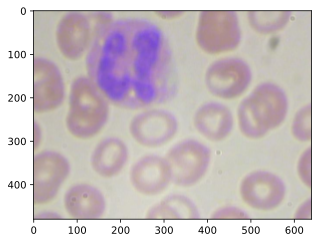

In [38]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), 
        threshold=0.9)